In [4]:
import subprocess
import json
import os
import time
import csv
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import glob
import matplotlib as mpl
import matplotlib.patches as mpatches
import nibabel as nib
import torch
import torch.nn as nn
import torch.nn.functional as F
import csv
dpi_default = mpl.rcParams['figure.dpi']
torch.set_printoptions(sci_mode=False)

def json_read(filename):
        if (os.path.isfile(filename)):
            with open(filename) as data_file:
                data = json.load(data_file)
            isfile=True;
        else:
            data={}
            isfile=False;
        return data, isfile     


PATH_TO_BMCR_data = '...'

In [4]:
experts = ["ANTs","A","H","N"]
datases = {}
mids = ["BMA","MBCA","MBM_v2","MBM_v3"]

for ex in experts:
    datases[ex] = {}
    
    table = None
    valid = None
    atlas_indx = None
    aindx = 0
    for m in mids:
        #f = db + m + "/annotations/landmarks_"+ex+".ano.json"
        f = PATH_TO_BMCR_data+"/validation_landmarks_atlases/landmarks_"+m+"_"+ex+".ano.json"
        lm, success = json_read(f)
        assert(success)
        lm_pts = np.array([pt["coords"] for pt in lm["annotations"][0]["points"]])[:,:3]
        lm_valid = np.array([pt["size"] for pt in lm["annotations"][0]["points"]])[:,None]
        
        if m == "MBCA":
            left_indx = [("left" in pt["name"]) for pt in lm["annotations"][0]["points"]]    
            right_indx = [("right" in pt["name"]) for pt in lm["annotations"][0]["points"]]    
            lm_pts[right_indx,:] = lm_pts[left_indx,:]
            lm_valid[right_indx,:] = lm_valid[left_indx,:]
        print(ex," ",m,"  ",lm_pts.shape)
        
        table = lm_pts[...,None] if table is None else np.concatenate((table,lm_pts[...,None]),axis=2)
        
        ain = np.ones(lm_pts[...,None].shape)*aindx
        atlas_indx = ain if  atlas_indx is None else np.concatenate((atlas_indx,ain),axis=2)
        
        valid = lm_valid[...,None] if valid is None else np.concatenate((valid,lm_valid[...,None]),axis=2)
        aindx += 1
        assert(success)
    datases[ex]["lm"] = table[:20,:,:]
    datases[ex]["valid"] = valid[:20,:,:]
    datases[ex]["aindx"] = atlas_indx[:20,:,:]
    
    if ex == "ANTs":
        lm_names = [pt["name"].replace("</span>&nbsp;"," ").replace('<span style="float: none;">',"").replace("Sup","sup") for pt in lm["annotations"][0]["points"]]
        lm_names = [pt.replace("midline1","midline") for pt in lm_names]
        lm_names = lm_names[:20]
lm_names        

ANTs   BMA    (22, 3)
ANTs   MBCA    (22, 3)
ANTs   MBM_v2    (22, 3)
ANTs   MBM_v3    (22, 3)
A   BMA    (22, 3)
A   MBCA    (22, 3)
A   MBM_v2    (22, 3)
A   MBM_v3    (22, 3)
H   BMA    (22, 3)
H   MBCA    (22, 3)
H   MBM_v2    (22, 3)
H   MBM_v3    (22, 3)
N   BMA    (22, 3)
N   MBCA    (22, 3)
N   MBM_v2    (22, 3)
N   MBM_v3    (22, 3)


['midline',
 'Anterior commisure',
 'anterior CC',
 'anterior Thalamus',
 'MB right',
 'MB left',
 'latThalamus right',
 'latThalamus left',
 'STN right',
 'STN left',
 'antCCtip right',
 'antCCtip left',
 'supThalamus right',
 'supThalamus left',
 'lat Cerebellum right',
 'lat Cerebellum left',
 'pons right',
 'pons left',
 'intersection ALIC/AC right',
 'intersection ALIC/AC left']

In [5]:
for ex in experts:
    print(ex)
    valid = np.min(datases[ex]["valid"],axis=(1,2))
    print(valid)


ANTs
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
A
[1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  0.5 0.5 1.  1.
 1.  1. ]
H
[1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  0.5 0.5 1.  1.
 1.  1. ]
N
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


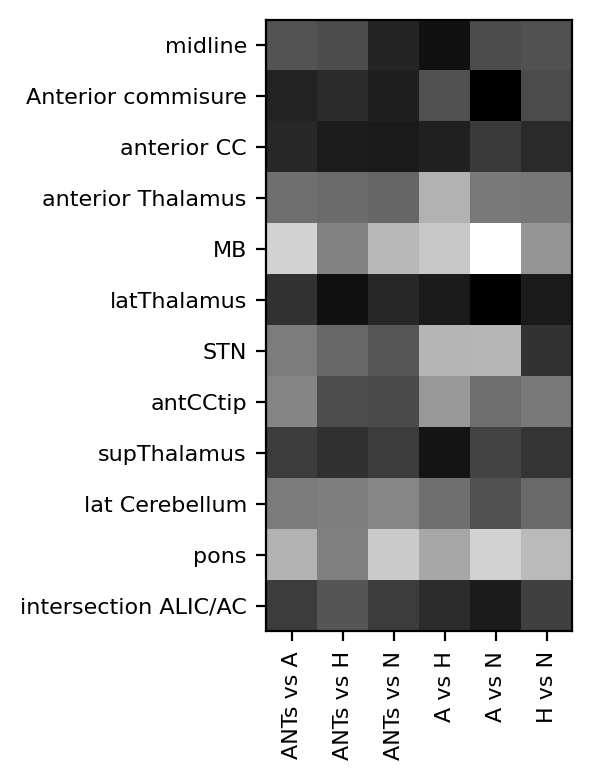

In [6]:
init = True
x_labels = []
y_labels = []

num_labels = 0

comb_legend = []


single_lm = [a for a,b in zip(range(len(lm_names)),lm_names) if not ("right" in b or "left" in b)]
left_lm = [a for a,b in zip(range(len(lm_names)),lm_names) if "left" in b]
right_lm = [a for a,b in zip(range(len(lm_names)),lm_names) if "right" in b]

lm_names_merged_lr = [lm_names[l] for l in single_lm] + [lm_names[l].replace(" left","") for l in left_lm]

all_dists = {}
all_dists_padded = {}

for ex1_ in range(len(experts)):
    ex1 = experts[ex1_]
    init2 = True
    for ex2_ in range(ex1_+1,len(experts)):
        ex2 = experts[ex2_]
        
        
        x_labels += [ex1 +" vs "+ ex2]
        comb_legend += [ex1 +" vs "+ ex2]
        
        D_ = datases[ex1]["lm"]-datases[ex2]["lm"]
        Ds = np.concatenate((D_[single_lm,:,:],D_[single_lm,:,:]),axis=2)
        
        #non symmetric landmarks only appear once. Ds is for the mean, but we use this one to count absolute values
        Ds_masked = np.concatenate((D_[single_lm,:,:],np.zeros(D_[single_lm,:,:].shape)),axis=2)
        Dlr = np.concatenate((D_[left_lm,:,:],D_[right_lm,:,:]),axis=2)
        
        D = np.concatenate((Ds,Dlr),axis=0)
        D_masked = np.concatenate((Ds_masked,Dlr),axis=0)
        
        
        M = np.sqrt(np.sum(D**2,axis=1))
        M_masked = np.sqrt(np.sum(D_masked**2,axis=1))
        
        all_dists_padded[ex1 +" vs "+ ex2] = M
        all_dists[ex1 +" vs "+ ex2] = M_masked
        
        M_mean = M.mean(axis=1)
        M_std = M.std(axis=1)

        M_mean_mat = M_mean[:,None] if init else np.concatenate((M_mean_mat,M_mean[:,None]),axis=1)
        M_std_mat = M_std[:,None] if init else np.concatenate((M_std_mat,M_std[:,None]),axis=1)
        init = False
            


mpl.rcParams['figure.dpi'] = 200
fig, ax = plt.subplots()
plt.imshow(M_mean_mat,cmap="gray")

ax.tick_params(axis='both', which='major', labelsize=8)
ax.set_xticks(np.arange(len(x_labels)))
ax.set_xticklabels(x_labels, rotation=90)

ax.set_yticks(np.arange(len(lm_names_merged_lr)))
ax.set_yticklabels(lm_names_merged_lr, rotation=0)

# Save the figure and show
plt.tight_layout()
plt.savefig('BMCR_Figures/Fig18/landmarks_matrix_ATLAS.pdf',bbox_inches='tight',  pad_inches = 0.1)
plt.show()        

best ANTS candidate  ANTs vs A
best ANTS candidate  ANTs vs H
best ANTS candidate  ANTs vs N


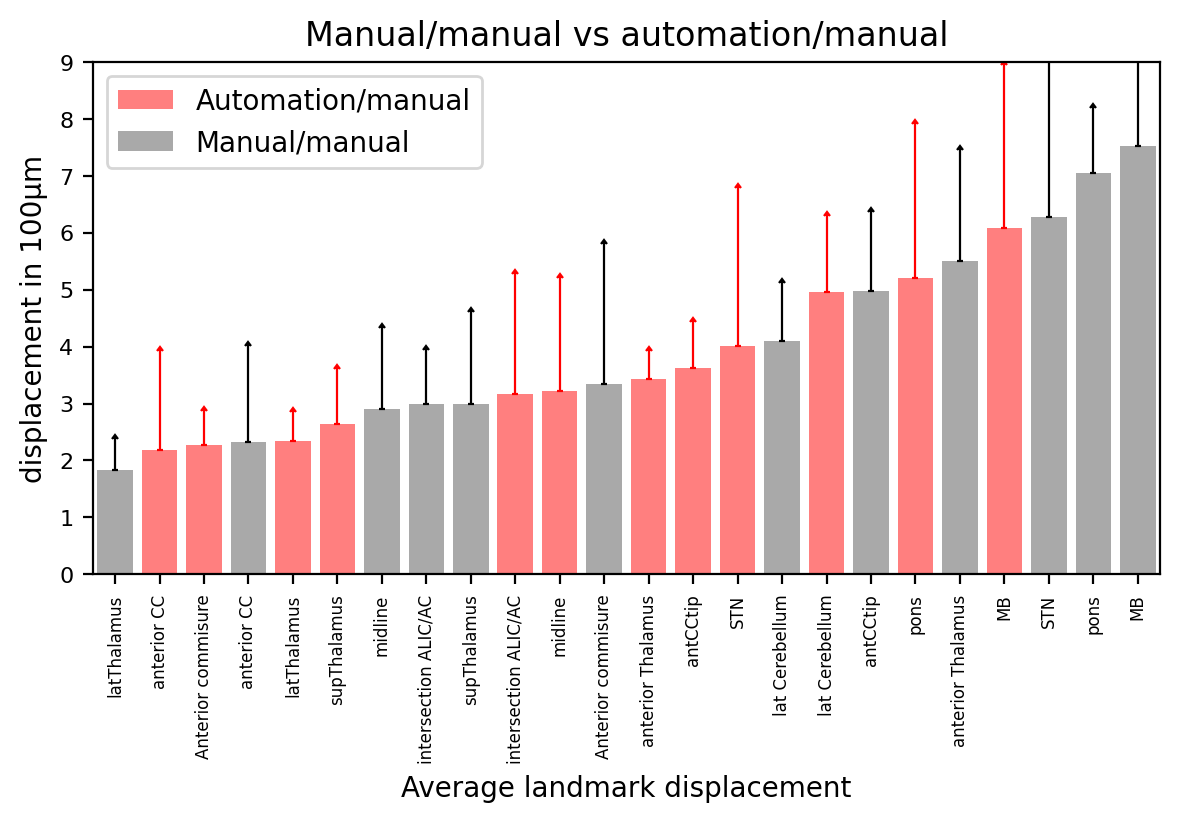

In [7]:
keys = list(all_dists.keys())

init = True
for a in range(3):
    print("best ANTS candidate ",keys[a])
    if init:
        init=False
        ants = all_dists_padded[keys[a]][...,None]
        human = all_dists_padded[keys[a+3]][...,None]
    else:
        ants = np.concatenate((ants,all_dists_padded[keys[a]][...,None]),axis=2)
        human = np.concatenate((human,all_dists_padded[keys[a+3]][...,None]),axis=2)
ants = np.sort(ants,axis=2)[:,:,1]
human = np.sort(human,axis=2)[:,:,1]     

ants_and_human = np.concatenate((ants[...,None],human[...,None]),axis=2)
M_mean = ants_and_human.mean(axis=1)
M_std = ants_and_human.std(axis=1)


M_mean_flattened = M_mean.reshape([-1])
M_std_flattened = M_std.reshape([-1])
flattened_indx = np.zeros(M_mean.shape)
flattened_indx[:] = np.arange(2)[None,:]
flattened_indx = flattened_indx.reshape([-1])

flattened_lindx = np.zeros(M_mean.shape)
flattened_lindx[:] = np.arange(M_mean.shape[0])[:,None]
flattened_lindx = flattened_lindx.reshape([-1])

sindx =  np.argsort(M_mean_flattened)
comb = np.unique(flattened_indx)

M_m_sort = M_mean_flattened[sindx]
M_s_sort = M_std_flattened[sindx]
M_i_sort = flattened_indx[sindx]
M_l_sort = flattened_lindx[sindx]

if True:
    x_pos = np.arange(flattened_indx.shape[0])
    fig, ax = plt.subplots()
    L = []

    for a in range(2):
        x_pos_ = x_pos[M_i_sort == a]
        y = M_m_sort[M_i_sort == a]
        ye = M_s_sort[M_i_sort == a]

        gray = (a % 3 ) / 3
        if a %2 == 0:
            ax.bar(x_pos_, y, yerr=ye,  align='center', alpha=0.5, ecolor='red', capsize=10, error_kw=dict(lw=0.8, capsize=1, capthick=0.8,lolims=True),color=(1,gray,gray,1))
        else:
            ax.bar(x_pos_, y, yerr=ye,  align='center', alpha=0.5, ecolor='black', capsize=10, error_kw=dict(lw=0.8, capsize=1, capthick=0.8,lolims=True),color=(gray,gray,gray,1))

    L = ["Automation/manual","Manual/manual"]
    ax.legend(L)

    ax.set_xticks(np.arange(len(M_l_sort)))
    ln = [lm_names_merged_lr[int(lm)] for lm in M_l_sort]
    ax.set_xticklabels(ln, rotation=90)

    ax.set_yticks(np.arange(10)/10.0)
    ax.set_yticklabels([str(a*1) for a in np.arange(10)], rotation=0)

    ax.set_ylabel("displacement in 100μm")
    ax.set_xlabel("Average landmark displacement")

    ax.tick_params(axis='x', which='major', labelsize=6)
    ax.tick_params(axis='y', which='major', labelsize=8)

    fig.tight_layout()
    plt.title("Manual/manual vs automation/manual")
    plt.ylim([0,0.9])
    plt.xlim([-0.5,len(x_pos)-0.5])
    
    plt.savefig('BMCR_Figures/Fig18/landmarks_displacement_sorted_ATLAS.pdf', bbox_inches = 'tight',  pad_inches = 0.1)
    plt.show()
    
    



best ANTS candidate  ANTs vs A
best ANTS candidate  ANTs vs H
best ANTS candidate  ANTs vs N


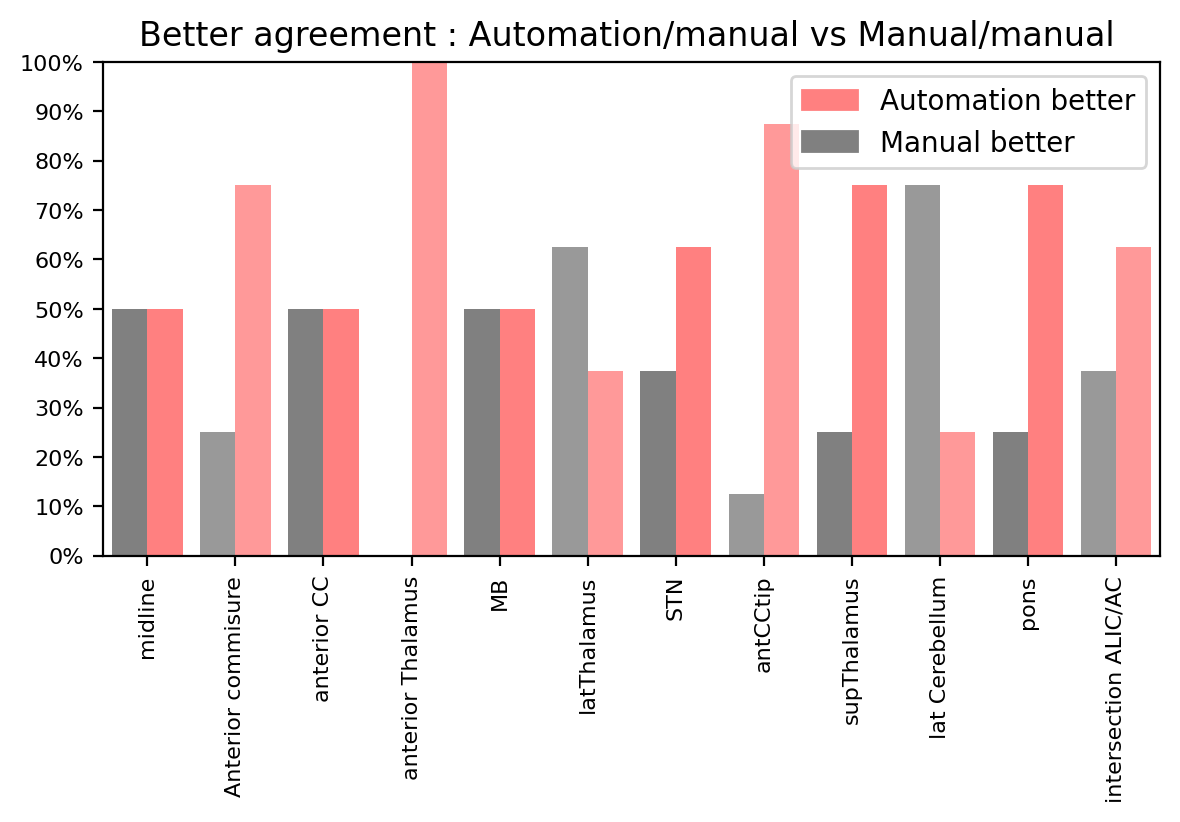

In [8]:
keys = list(all_dists.keys())

init = True
for a in range(3):
    print("best ANTS candidate ",keys[a])
    if init:
        init=False
        ants = all_dists[keys[a]][...,None]
        human = all_dists[keys[a+3]][...,None]
    else:
        ants = np.concatenate((ants,all_dists[keys[a]][...,None]),axis=2)
        human = np.concatenate((human,all_dists[keys[a+3]][...,None]),axis=2)
            

ants = np.sort(ants,axis=2)[:,:,1]
human = np.sort(human,axis=2)[:,:,1]
            
ants_worse_than_human = (ants>human).sum(axis=1)            
human_worse_than_ants = (ants<human).sum(axis=1)            


x_pos = np.arange(ants_worse_than_human.shape[0])
fig, ax = plt.subplots()
for a in range(2):
    norm = ants_worse_than_human + human_worse_than_ants
    offset = 0.1
    if a == 0:   
        hatch = "/"
        hatch = ".O"
        hatch = ".."
        hatch = "x."
        hatch = "*"
        hatch = "."
        for b in range(len(x_pos)):
            hatch = "/" if b%2==0 else "."
            hatch = ""
            color = (0.5,0.5,0.5,1) if b%2==0 else (0.6,0.6,0.6,1)
            ax.bar(x_pos[b]*2+offset, ants_worse_than_human[b]/norm[b], align='center', alpha=1, ecolor='red', capsize=10,color=color, hatch=hatch)
    else:
        for b in range(len(x_pos)):
            hatch = "/" if b%2==0 else "."
            hatch = ""
            color = (1.0,0.5,0.5,1) if b%2==0 else (1.0,0.6,0.6,1)
            ax.bar(x_pos[b]*2+1-offset, human_worse_than_ants[b]/norm[b], align='center', alpha=1, ecolor='red', capsize=10,color=color, hatch=hatch)


gray_patch = mpatches.Patch(color=(0.5,0.5,0.5,1), label="Manual better")
red_patch = mpatches.Patch(color=(1.0,0.5,0.5,1), label="Automation better")

plt.legend(handles=[red_patch,gray_patch])

ax.tick_params(axis='both', which='major', labelsize=8)
ax.set_xticks(np.arange(len(lm_names_merged_lr))*2+0.5)
ax.set_xticklabels(lm_names_merged_lr, rotation=90)


ax.set_yticks(np.arange(11)/10)
ax.set_yticklabels([str(a*10)+"%" for a in np.arange(11)])

ax.set_ylabel("")

fig.tight_layout()
plt.title("Better agreement : Automation/manual vs Manual/manual ")
plt.xlim([-0.5,2*len(ants_worse_than_human)-0.5])
plt.ylim([0,1])

plt.savefig('BMCR_Figures/Fig18//landmarks_displacement_scores_ATLAS.pdf', bbox_inches = 'tight',  pad_inches = 0.1)
plt.show()



In [ ]:
15159521000.0

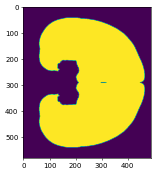

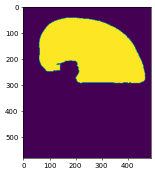

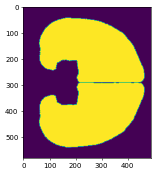

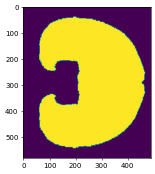

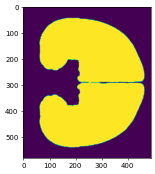

In [2]:
import sys

#sys.path.append("/disk/soft/bia_software/nifti_tools/")
#from bia_nifti import reslice


mpl.rcParams['figure.dpi'] = 50

STPT_files = PATH_TO_BMCR_data+'/validation_landmarks_atlases/'
atlases = ['STPT','MBCA','MBM_v2','MBM_v3','BMA']
atlases_c = ['MBCA','MBM_v2','MBM_v3','BMA']

target_res = [256, 356, 230]

fn = STPT_files+'STPT'+'_cmask.nii.gz'
ref = nib.load(fn)

affines = {}
adata = {}

for a in atlases:
    
    fn = STPT_files+a+'_cmask_resliced.nii.gz'
    if os.path.isfile(fn):
        adata[a] =  nib.load(fn).get_fdata(dtype=np.float32)
    else:
        assert(False)
        # we provide the resliced files
        # you should not end up here
        fn = STPT_files+a+'_cmask.nii.gz'
        src = nib.load(fn)
        affines[a] = src.affine
        tmp = (src.get_fdata(dtype=np.float32)>0).astype(np.uint16)
        adata[a] = reslice(tmp,
                           src.affine,
                           ref.shape,
                           ref.affine)

        if False:
            new_image = nib.Nifti1Image((adata[a]>0).astype(np.uint8), affine=ref.affine)
            new_image.header["cal_min"] = 0
            new_image.header["cal_max"] = 1
            new_image.header["scl_slope"] = 1/255.0
            new_image.header["scl_inter"] = 0
            nib.save(new_image,STPT_files+a+'_cmask_resliced.nii.gz') 

    plt.imshow(adata[a].max(axis=1))
    plt.show()
    


In [15]:
#plt.immshow()
#adata["STPT"][:580//2,:,:].shape
#plt.imshow(B.max(axis=0))
#(A*B).sum()
#plt.imshow(A.max(axis=1))


{'MBCA': {'dice': 0.9612179772656355}, 'MBM_v2': {'dice': 0.9587160283655588}, 'MBM_v3': {'dice': 0.9552016198832544}, 'BMA': {'dice': 0.9412878667557386}}


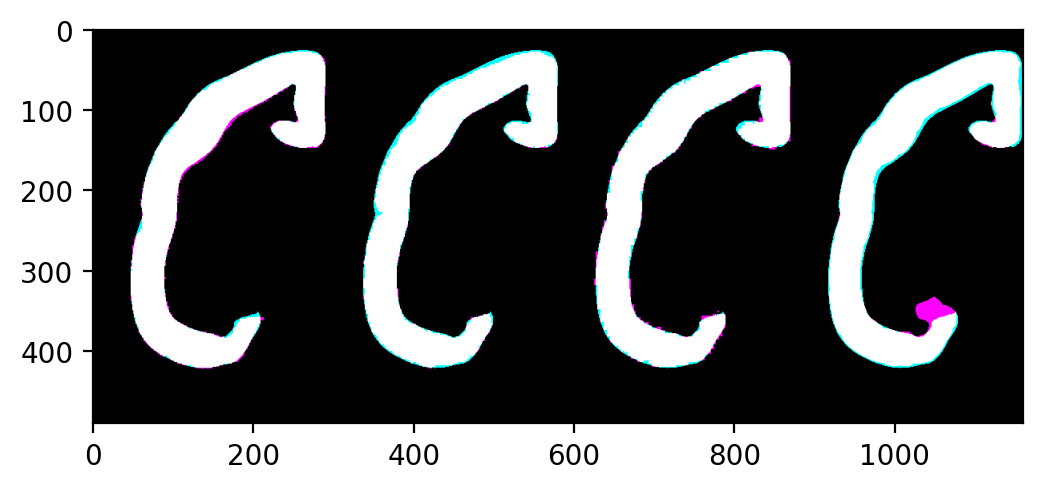

In [16]:
mpl.rcParams['figure.dpi'] = 200
overview = None
scores = {}
B = (adata["STPT"][:580//2,:,:] > 0).astype(np.float32)
for c in atlases_c:
    r = {}
    A = (adata[c][:580//2,:,:] > 0).astype(np.float32)
    inters_v = (A*B).sum()
    v_a = A.sum()
    v_b = B.sum()
    r["dice"] = inters_v*2/(v_a+v_b)
    scores[c] = r
    
    tmp = np.concatenate(
    (adata[c][:580//2,400,:,None]*255,
     adata["STPT"][:580//2,400,:,None]*255,
    np.maximum(adata[c][:580//2,400,:,None],adata["STPT"][:580//2,400,:,None])*255
    ),axis=2)
    
    if overview is None:
        overview = tmp
    else:
        overview = np.concatenate((overview,tmp),axis=0)
    

overview = np.rot90(overview,k=3,axes=[1,0])
plt.imshow(overview)
print(scores)

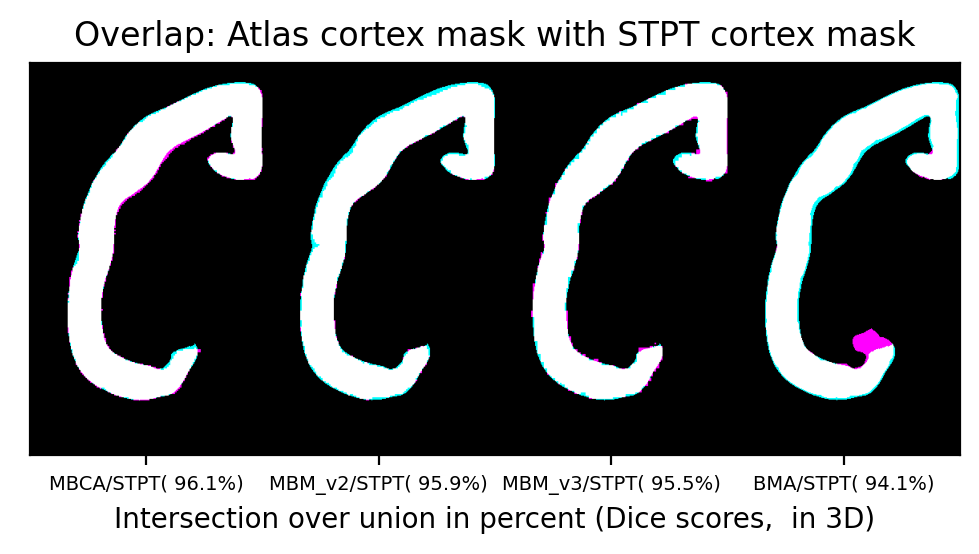

In [17]:
fig, ax = plt.subplots()

ax.imshow(overview)

ax.tick_params(axis='both', which='major', labelsize=8)
ax.set_xticks(np.arange(4)*overview.shape[1]//4+overview.shape[1]//8)
ax.set_xticklabels([a+"/STPT"+"( {:.1f}%)".format((100*scores[a]["dice"])) for a in atlases_c], rotation=0)

plt.yticks([], [])

ax.set_xlabel("Intersection over union in percent (Dice scores,  in 3D)")

ax.tick_params(axis='x', which='major', labelsize=7)

plt.title("Overlap: Atlas cortex mask with STPT cortex mask")

plt.savefig('BMCR_Figures/Fig18/atlas_cortex_overlaps.pdf', bbox_inches = 'tight',  pad_inches = 0.1)
plt.show()